In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.offline as po
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 8,5
plt.style.use('fivethirtyeight')

In [3]:
trans = pd.read_excel('transaction.xlsx')
print(trans.shape)
trans.head()

(500, 7)


,amount,a/c_number,trans_type,description,reference_number,trans_branch,datetime
0,200.0,070******357,Debited,AIRTIME/ MTN/08169327250,099MJKL222600FUo,HEAD OFFICE,2022-09-17 04:45:42
1,300.0,070******357,Debited,AIRTIME/ MTN/08168550974,099MJKL22258SUsT,HEAD OFFICE,2022-09-16 03:20:03
2,500.0,070******357,Debited,TRF/From TelRich Services/FRM GOODRICH IFE,099MJKL22258LPM0,HEAD OFFICE,2022-09-15 23:29:28
3,200.0,070******357,Debited,AIRTIME/ MTN/08169327250,099MJKL2225802x3,HEAD OFFICE,2022-09-15 05:07:19
4,300.0,070******357,Debited,AIRTIME/ MTN/08168550974,099MJKL22257SR8s,HEAD OFFICE,2022-09-15 03:08:11


There are more debit transaction than credits

In [4]:
transaction_type = trans['trans_type'].value_counts()
label = transaction_type.index
size = transaction_type.values
colors = ['lightgreen', 'aqua']

trace = go.Pie(
    labels=label,
    values=size,
    marker=dict(colors=colors),
)

data = [trace]
layout = go.Layout(title="Transaction Type Distribution")
fig = go.Figure(data=data, layout=layout)
po.iplot(fig)

We can say head office handle most of the transactions

In [5]:
transaction_branch = trans['trans_branch'].value_counts()
label = transaction_branch.index
size = transaction_branch.values
colors = ['aqua', 'lightgreen', 'lightgrey', 'khaki']

trace = go.Pie(
    labels=label,
    values=size,
    marker=dict(colors=colors)
)

data = [trace]
layout = go.Layout(title = 'Transaction Branch Distribution')
fig = go.Figure(data=data, layout=layout)
po.iplot(fig)

Credit Transactions has the highest average amount

In [6]:
trans_type_mean = round(trans.groupby('trans_type')['amount'].mean().to_frame(), 2)
trace = go.Bar(
    x=trans_type_mean.index,
    y=trans_type_mean.amount,
    marker=dict(color=trans_type_mean.amount, 
                colorscale='Reds')
)

data = [trace]
layout = go.Layout(title = 'Average Amount Used in Transaction Type',
                   yaxis = dict(title = 'Amount in Naira'))
fig= go.Figure(data=data, layout=layout)
po.iplot(fig)

Head office has the highest mean amount of transactions.

In [7]:
trans_type_mean = round(trans.groupby('trans_branch')['amount'].mean(), 2).\
                    sort_values(ascending=False).to_frame()
trace = go.Bar(
    x=trans_type_mean.index,
    y=trans_type_mean.amount,
    marker=dict(color=trans_type_mean.amount, 
                colorscale='Reds')
)

data = [trace]
layout = go.Layout(title = 'Average Amount Handled by Each Branch',
                   yaxis = dict(title = 'Amount in Naira'))
fig= go.Figure(data=data, layout=layout)
po.iplot(fig)

Description Distribution

In [8]:
trans_copy = trans.copy()
trans_copy['description'] = np.where(trans_copy['description'].str.contains('airtime', case=False), 'Airtime_Purchase',
                                trans_copy['description'])
trans_copy['description'] = np.where(trans_copy['description'].str.contains(r'\bPOS\b'), 'POS_Transaction',
                                trans_copy['description'])
trans_copy['description'] = np.where(trans_copy['description'].str.contains(r'\bTRF\b|Transfer|TRANSFER|TFR'), 'Transfer',
                                trans_copy['description'])
trans_copy['description'] = np.where(trans_copy['description'].str.contains('USSD'), 'USSD_Transaction',
                                trans_copy['description'])
df = trans_copy['description'].value_counts().reset_index(name='counts')
df1 = df[:4].copy()

new_row = pd.DataFrame(data={
    'index': ['other transaction'],
    'counts': [df['counts'][4:].sum()]
})

df2 = pd.concat([df1, new_row], ignore_index=True)
df2

label = df2['index']
size = df2.counts
colors = ['aqua', 'lightgreen']

trace = go.Pie(
    labels=label,
    values=size,
    marker=dict(colors=colors)
)

data = [trace]
layout = go.Layout(title='Alert Description')
fig = go.Figure(data=data, layout=layout)
po.iplot(fig)

In [9]:
Airtime = trans_copy[trans_copy['description'] == 'Airtime_Purchase']
Airtime['trans_branch'].unique()


array(['HEAD OFFICE'], dtype=object)

In [10]:
Transfer = trans_copy[trans_copy['description'] == 'Transfer']
Transfer['trans_branch'].unique()

array(['HEAD OFFICE', 'NEKEDE BRANCH'], dtype=object)

In [11]:
Pos = trans_copy[trans_copy['description'] == 'POS_Transaction']
Pos['trans_branch'].unique()

array(['CENTRAL PROCESSING BRANCH', 'HEAD OFFICE'], dtype=object)

In [12]:
ussd = trans_copy[trans_copy['description'] == 'USSD_Transaction']
ussd['trans_branch'].unique()

array(['HEAD OFFICE'], dtype=object)

In [13]:
trans_copy = trans_copy.set_index('datetime')
trans_copy

,amount,a/c_number,trans_type,description,reference_number,trans_branch
datetime,,,,,,
2022-09-17 04:45:42,200.00,070******357,Debited,Airtime_Purchase,099MJKL222600FUo,HEAD OFFICE
2022-09-16 03:20:03,300.00,070******357,Debited,Airtime_Purchase,099MJKL22258SUsT,HEAD OFFICE
2022-09-15 23:29:28,500.00,070******357,Debited,Transfer,099MJKL22258LPM0,HEAD OFFICE
2022-09-15 05:07:19,200.00,070******357,Debited,Airtime_Purchase,099MJKL2225802x3,HEAD OFFICE
2022-09-15 03:08:11,300.00,070******357,Debited,Airtime_Purchase,099MJKL22257SR8s,HEAD OFFICE
...,...,...,...,...,...,...
2021-12-09 18:10:53,1600.00,070******357,Credited,JOSEPH EPHRAIM MARK/PAYMENT,099MNIP213433oEZ,HEAD OFFICE
2021-12-09 16:29:36,2510.75,070******357,Debited,Transfer,099MJKL213438671,HEAD OFFICE
2021-12-09 15:59:13,3010.75,070******357,Debited,Transfer,099MJKL213437Lsq,HEAD OFFICE


In [19]:
trans_copy.groupby(by=trans_copy.index.month)['amount'].sum()

datetime
1     206475.13
2     117178.63
3     116000.13
4     118605.00
5      91240.63
6      84723.38
7     107131.88
8     529029.46
9      51721.50
12    421508.35
Name: amount, dtype: float64

In [72]:
a = trans_copy.groupby(by=[trans_copy.index.year, trans_copy.index.month])['amount'].sum().to_frame()
a

amount
datetime datetime           
2021     12        421508.35
2022     1         206475.13
         2         117178.63
         3         116000.13
         4         118605.00
         5          91240.63
         6          84723.38
         7         107131.88
         8         529029.46
         9          51721.50

In [73]:
a = a.reset_index(level= 1)
a.rename(columns={'datetime':'month'}, inplace=True)
a.reset_index(inplace=True)

In [75]:
a.columns=['year', 'month', 'amount']
a

,year,month,amount
0,2021,12,421508.35
1,2022,1,206475.13
2,2022,2,117178.63
3,2022,3,116000.13
4,2022,4,118605.00
5,2022,5,91240.63
6,2022,6,84723.38
7,2022,7,107131.88
8,2022,8,529029.46
9,2022,9,51721.50


In [100]:
a = trans_copy.groupby(by=[trans_copy.index.year, trans_copy.index.month, 'trans_type'])['amount'].sum().to_frame()
a

amount
datetime datetime trans_type           
2021     12       Credited    210148.00
                  Debited     211360.35
2022     1        Credited     96250.00
                  Debited     110225.13
         2        Credited     56376.00
                  Debited      60802.63
         3        Credited     58600.00
                  Debited      57400.13
         4        Credited     59300.00
                  Debited      59305.00
         5        Credited     46662.50
                  Debited      44578.13
         6        Credited     46600.00
                  Debited      38123.38
         7        Credited     55450.00
                  Debited      51681.88
         8        Credited    349079.88
                  Debited     179949.58
         9        Credited     15000.00
                  Debited      36721.50

In [102]:
a.reset_index(level=1, inplace=True)
a


,trans_type,datetime,amount
datetime,,,
2021,Credited,12,210148.00
2021,Debited,12,211360.35
2022,Credited,1,96250.00
2022,Debited,1,110225.13
2022,Credited,2,56376.00
2022,Debited,2,60802.63
2022,Credited,3,58600.00
2022,Debited,3,57400.13
2022,Credited,4,59300.00


In [104]:
a.rename(columns={'datetime':'month'}, inplace=True)

In [107]:
a.reset_index(inplace=True)

In [111]:
a

,datetime,trans_type,month,amount
0,2021,Credited,12,210148.00
1,2021,Debited,12,211360.35
2,2022,Credited,1,96250.00
3,2022,Debited,1,110225.13
4,2022,Credited,2,56376.00
5,2022,Debited,2,60802.63
6,2022,Credited,3,58600.00
7,2022,Debited,3,57400.13
8,2022,Credited,4,59300.00
9,2022,Debited,4,59305.00


In [112]:
b = a[2:]
b

,datetime,trans_type,month,amount
2,2022,Credited,1,96250.00
3,2022,Debited,1,110225.13
4,2022,Credited,2,56376.00
5,2022,Debited,2,60802.63
6,2022,Credited,3,58600.00
7,2022,Debited,3,57400.13
8,2022,Credited,4,59300.00
9,2022,Debited,4,59305.00
10,2022,Credited,5,46662.50
11,2022,Debited,5,44578.13


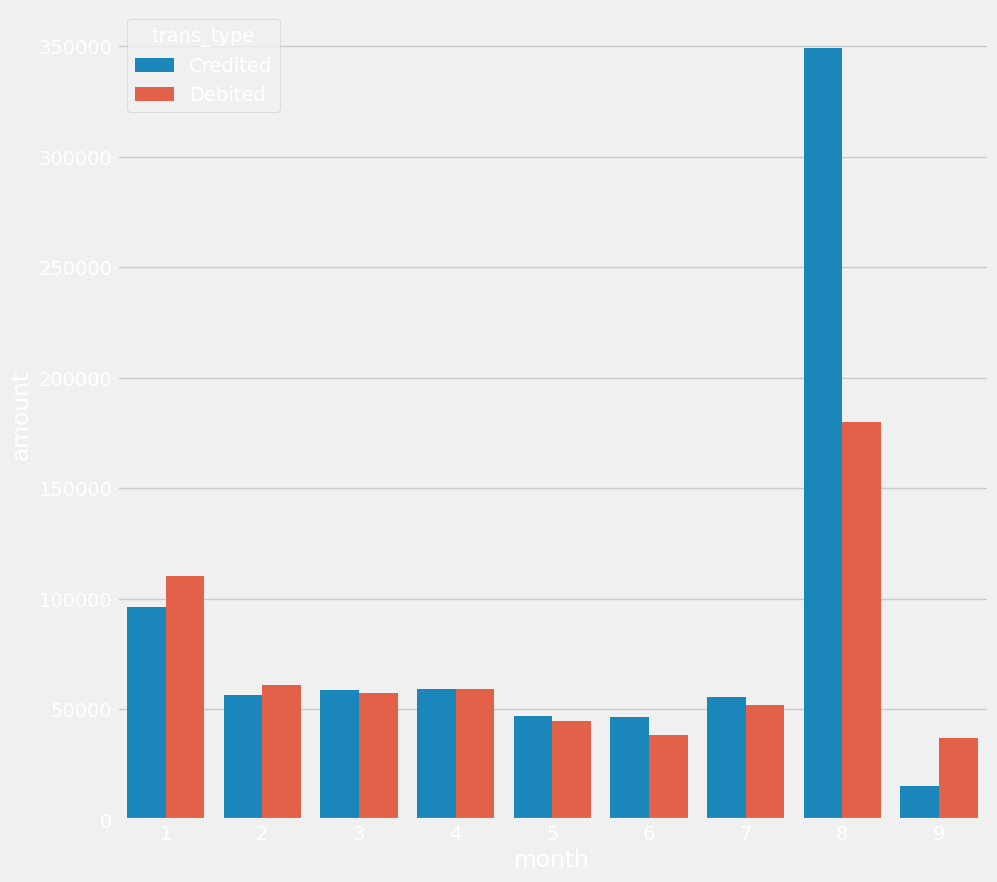

In [116]:
import seaborn as sb
fig, ax1 = plt.subplots(figsize=(10,10))
sb.barplot(x='month', y='amount', hue='trans_type', data=b, ax=ax1)
sb.despine(fig)

In [16]:
trans_copy[trans_copy['description'].str.contains(r'\bCOMM\b')]

,amount,a/c_number,trans_type,description,reference_number,trans_branch
datetime,,,,,,
2022-08-16 01:59:08,10.75,070******357,Debited,Amt includes COMM & VAT/Account Balance,099MJKL22227W7xj,HEAD OFFICE
